## Modules import / Импортирование модулей

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from time import time

## Data import and splitting

In [4]:
data = pd.read_csv('lab2_oil_gas_field_construction_data.csv')
embeddings_train = pd.read_csv('x_train.csv')
embeddings_val = pd.read_csv('x_val.csv')

In [5]:
marked_data = data[((data.generalized_work_class.notna())) & (data.global_work_class.notna())] # Select the data labelled by both class fields

train, val = train_test_split(
    marked_data, test_size=0.05, train_size=0.95, random_state=42)

print(f'The training dataset size is {train.shape[0]} records, or {100 * train.shape[0]/marked_data.shape[0]:.2f} % of the data available for training.')
print(f'The validation dataset size is {val.shape[0]} records, or {100 * val.shape[0]/marked_data.shape[0]:.2f} % of the data available for training.')

The training dataset size is 282015 records, or 95.00 % of the data available for training.
The validation dataset size is 14843 records, or 5.00 % of the data available for training.


## Subsets forming and targets encoding

In [6]:
# Unknown categories will be encoded as -1 to avoid unexpected crashes
# In case of -1's appearance train_test_split with different random_state should be performed
generalized_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
global_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [43]:
X_train_raw = train.work_name
y1_train = pd.Series(
    generalized_encoder.fit_transform(
        train.generalized_work_class.values.reshape(-1, 1) # "Reshape" to make encoder work properly
    ).flatten(), # "Flatten" to obtain list of values instead of list of lists with values
    index=train.index,
)
y2_train = pd.Series(
    global_encoder.fit_transform(
        train.global_work_class.values.reshape(-1, 1)
    ).flatten(),
    index=train.index,
)

In [44]:
X_val_raw = val.work_name
y1_val = pd.Series(
    generalized_encoder.transform(
        val.generalized_work_class.values.reshape(-1, 1)
    ).flatten(),
    index=val.index,
)
y2_val = pd.Series(
    global_encoder.transform(val.global_work_class.values.reshape(-1, 1)).flatten(),
    index=val.index,
)

In [9]:
display(y1_train.head(10))

225625    165.0
238367     28.0
357855    139.0
270696    171.0
54329      35.0
444519    149.0
45285     157.0
542407    139.0
697845    188.0
498760    117.0
dtype: float64

In [10]:
display(y2_train.head(10))

225625    32.0
238367    12.0
357855    34.0
270696    51.0
54329     15.0
444519    36.0
45285     26.0
542407    34.0
697845    44.0
498760    26.0
dtype: float64

## Features loading


In [11]:
embeddings_train.drop(columns=['Unnamed: 0'], inplace=True)
embeddings_val.drop(columns=['Unnamed: 0'], inplace=True)

In [12]:
X_train = pd.DataFrame(embeddings_train.values, index=train.index)
X_val = pd.DataFrame(embeddings_val.values, index=val.index)

In [16]:
X_train.sample(3, random_state=42)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
154276,0.113643,0.014277,-0.015322,-0.033846,-0.051642,0.052199,-0.024451,-0.005593,0.044588,-0.048071,...,-0.066962,0.040657,-0.029578,0.070915,-0.013325,0.074499,-0.069606,-0.009099,0.033147,0.028903
687997,0.091818,0.040785,-0.061397,0.049828,-0.102584,0.024915,0.007012,0.080604,0.027978,0.051415,...,-0.053080,-0.020653,0.051529,0.087559,0.015842,0.052521,0.056413,0.012658,0.007800,0.055728
108560,0.028982,0.008540,-0.073775,-0.059660,-0.069658,0.083254,-0.049393,0.082266,0.062147,0.041122,...,-0.028273,0.007476,-0.012896,0.082432,-0.018309,-0.029180,0.033281,-0.034215,-0.043049,0.023154


## Model training

In [29]:
class MultiLogisticRegression():
    def __init__(self, n_estimators: int, max_iter: int = 200):
        '''
        Create a list of estimators with specified max_iter
        '''
        self.estimators = []
        for _ in range(n_estimators):
            self.estimators.append(LogisticRegression(max_iter=max_iter))

    def fit(self, X, y_list):
        '''
        Fit each estimator of the list using provided features and targets
        '''
        i = 1
        for estimator, y in zip(self.estimators, y_list):
            print(f'Fitting estimator #{i}')
            estimator.fit(X, y)
            i += 1
        
    def predict(self, X):
        '''
        Obtain each estimator's predictions using provided features
        '''
        predictions = []
        for i, estimator in enumerate(self.estimators):
            print(f'Obtaining predictions of the #{i+1} estimator')
            predictions.append(estimator.predict(X))
        return predictions
    
    
    def predict_proba(self, X):
        '''
        Obtain each estimator's predictions using provided features
        '''
        predictions = []
        for i, estimator in enumerate(self.estimators):
            print(f'Obtaining predictions of the #{i+1} estimator')
            predictions.append(estimator.predict_proba(X))
            
        return predictions

        

In [30]:
lr_model = MultiLogisticRegression(n_estimators=2, max_iter=450)

In [31]:
lr_model.fit(X_train, [y1_train, y2_train]) # 12:43 - 53

Fitting estimator #1
Fitting estimator #2


## Trained model validation

In [32]:
# %%timeit
predictions = lr_model.predict(X_val) # Obtain class predictions

Obtaining predictions of the #1 estimator
Obtaining predictions of the #2 estimator


In [33]:
f1_score_1_micro = f1_score(y1_val, predictions[0], average='micro') # Generalized_work_class F1 micro
f1_score_2_micro = f1_score(y2_val, predictions[1], average='micro') # Global_work_class F1 micro

f1_score_1_macro = f1_score(y1_val, predictions[0], average='macro') # Generalized_work_class F1 macro
f1_score_2_macro = f1_score(y2_val, predictions[1], average='macro') # Global_work_class F1 macro

total_f1_score_micro = np.mean((f1_score_1_micro, f1_score_2_micro)) # Total F1 micro score
total_f1_score_macro = np.mean((f1_score_1_macro, f1_score_2_macro)) # Total F1 macro score

In [34]:
pd.DataFrame(
    {
    'generalized_work_class': [f1_score_1_micro, f1_score_1_macro],
    'global_work_class': [f1_score_2_micro, f1_score_2_macro],
    'total': [total_f1_score_micro, total_f1_score_macro]
    },
    index=['F1 micro', 'F1 macro']
).round(3) # Form a summarised table with rounded metric values

,generalized_work_class,global_work_class,total
F1 micro,0.980,0.976,0.978
F1 macro,0.792,0.823,0.807


In [35]:
probas = lr_model.predict_proba(X_val) 
# shape = list of two np.array of shape (14843, 207)

Obtaining predictions of the #1 estimator
Obtaining predictions of the #2 estimator


In [38]:
np.save("independent_general.npy", probas[0])
np.save("independent_global.npy", probas[1])

In [42]:
pd.DataFrame(probas[0], index=X_val_raw.index).to_csv("independent_general.csv")
pd.DataFrame(probas[1], index=X_val_raw.index).to_csv("independent_global.csv")

In [45]:
# Для прочтения вероятностей использовать:
# preds_from_csv = pd.read_csv("independent_general.csv", index_col="Unnamed: 0")

## Conclusion / Вывод

`ENG`

The overall F1 value of micro = 0.978 is close to 1. This means that the model performs well in classifying the data and achieves a high measure of consistency between accuracy* and completeness**.   

At the same time, the overall value of the F1 macro metric shows that there are problems in the predictions for sparse classes. In the context of our task, this means that for sparse classes the model is significantly likely to assign a more popular class of tasks with close semantic meaning. To solve this problem, the number of records with rare classes should be increased.

(Micro average F1 score performs worse on imbalanced datasets than macro average F1 score. The reason for this is because micro F1 gives equal importance to each observation, whilst macro F1 gives each class equal importance.

When micro F1 score gives equal importance to each observation this means that when the classes are imbalanced, those classes with more observations will have a larger impact on the final score. Resulting in a final score which hides the performance of the minority classes and amplifies the majority.

On the other hand, macro F1 score gives equal importance to each class. This means that a majority class will contribute equally along with the minority, allowing macro f1 to still return objective results on imbalanced datasets.)

`RU`

Общее значение F1 micro = 0.978 близко к 1. Это означает, что модель хорошо справляется с классификацией данных и достигает высокой меры согласованности между точностью* и полнотой**.   

В то же время, общее значение метрики F1 macro показывает наличие проблем в предсказаниях для малочисленных классов. В контексте нашей задачи это означает, что редким классам модель с значительной долей вероятности назначит более популярный класс задач с близким семантическим смыслом. Для решения этой проблемы следует увеличить число записей с редкими классами.

*Точность (precision) измеряет, как много из предсказанных как положительные примеры на самом деле являются положительными. Большое значение точности означает, что модель делает мало ложных положительных предсказаний.

**Полнота (recall) измеряет, как много из всех положительных примеров модель смогла найти. Большое значение полноты означает, что модель находит много положительных примеров.

## Testing 1st hypothesis

### EDA + keys with surjection

In [13]:
key_pairs_info = marked_data.groupby(["generalized_work_class", "global_work_class"]).size()

keys1, keys2 = [], []
for key1, key2 in list(key_pairs_info.index):
    keys1.append(key1)
    keys2.append(key2)

In [14]:
key_pairs_info_idx = pd.DataFrame(list(zip(keys1, keys2)), columns=["generalized_work_class", "global_work_class"])

first_key_counted = key_pairs_info_idx.groupby("generalized_work_class").count()
first_key_counted.loc[first_key_counted['global_work_class'] > 1]

,global_work_class
generalized_work_class,
Монтаж блок-бокса,2
Монтаж крана,2
Монтаж электрооборудования,2


In [15]:
no_sur_keys = list(first_key_counted.loc[first_key_counted['global_work_class'] > 1].index)

sum(marked_data["generalized_work_class"].isin(no_sur_keys))

1050

In [69]:
len(marked_data)

296858

In [72]:
print(f"{1050 * 100 / len(marked_data):.2f}% of labeled data with no surjection first key")

0.35% of labeled data with no surjection first key


### Splitting val into surjectioned and non-surjectioned

In [86]:
~key_pairs_info_idx.generalized_work_class.duplicated(keep=False)
len(key_pairs_info_idx.generalized_work_class[~key_pairs_info_idx.generalized_work_class.duplicated(keep=False)])

204

In [16]:
sur_first_keys = key_pairs_info_idx.generalized_work_class[~key_pairs_info_idx.generalized_work_class.duplicated(keep=False)]
sur_first_keys.head(1)

0    АКЗ мк
Name: generalized_work_class, dtype: object

In [17]:
marked_data["Index"] = pd.Series(marked_data.index, index=marked_data.index)

sur_marked_data = marked_data.merge(sur_first_keys, 
                                    on="generalized_work_class").set_index("Index")
# sur_marked_data.drop(columns=["upper_works"], inplace=True)
# sur_marked_data.dropna(axis=1, inplace=True)
len(sur_marked_data)

C:\Users\Ivik12S\AppData\Local\Temp\ipykernel_10752\3143052891.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marked_data["Index"] = pd.Series(marked_data.index, index=marked_data.index)


295808

In [18]:
no_sur_marked_idx = marked_data[marked_data["generalized_work_class"].isin(no_sur_keys)]
no_sur_marked_idx.head(1)

,work_name,generalized_work_class,global_work_class,upper_works,Index
623,монтаж блок бокса бу,Монтаж блок-бокса,Монтаж блок-бокса,NaN,623


In [19]:
len(no_sur_marked_idx)

1050

In [20]:
val_idx = pd.DataFrame(y1_val.index, columns=["idx"])
val_idx_no_sur = val_idx[list(val_idx.idx.isin(no_sur_marked_idx.index))]
val_idx_sur = val_idx[list(val_idx.idx.isin(sur_marked_data.index))]
print("Len of no surjection keys:", len(val_idx_no_sur))
print("Len of surjection keys:", len(val_idx_sur))

Len of no surjection keys: 48
Len of surjection keys: 14795


In [21]:
y1_val_sur = y1_val.iloc[list(val_idx_sur.index)]
y2_val_sur = y2_val.iloc[list(val_idx_sur.index)]

y1_val_no_sur = y1_val.iloc[list(val_idx_no_sur.index)]
y2_val_no_sur = y2_val.iloc[list(val_idx_no_sur.index)]
len(y2_val_sur)

14795

### Defining global classes by general classes

In [32]:
sur_keys_data = sur_marked_data[["generalized_work_class", "global_work_class"]].drop_duplicates()
len(sur_keys_data)

204

In [205]:
model1_preds = pd.Series(predictions[0], index=y1_val.index, name="generalized_work_class")
model2_preds = pd.Series(predictions[1], index=y1_val.index, name="global_work_class")
model1_preds.head(2)

400713    165.0
195157    188.0
Name: generalized_work_class, dtype: float64

In [194]:
row1 = pd.Series(
    generalized_encoder.transform(sur_keys_data \
                             .generalized_work_class \
                             .values.reshape(-1, 1)) \
                             .flatten(),
    name="generalized_work_class")

row2 = pd.Series(
    global_encoder.transform(sur_keys_data \
                             .global_work_class \
                             .values.reshape(-1, 1)) \
                             .flatten(),
    name="global_work_class")

sur_keys_encoded = pd.concat([row1, row2], axis=1)
sur_keys_encoded.head(2)

,generalized_work_class,global_work_class
0,132.0,54.0
1,157.0,26.0


In [206]:
models_def_preds = model1_preds.to_frame()\
            .merge(sur_keys_encoded, on="generalized_work_class", how="left")\
            .set_index(y1_val.index)
models_def_preds.head(2)

,generalized_work_class,global_work_class
400713,165.0,32.0
195157,188.0,44.0


In [214]:
idxs = models_def_preds.global_work_class[models_def_preds.global_work_class.isna()].index
len(idxs)

48

In [216]:
models_def_preds.loc[idxs, "global_work_class"] = model2_preds[idxs]

In [220]:
gen_pred = models_def_preds.generalized_work_class.values
glob_pred = models_def_preds.global_work_class.values

f1_score_1_micro = f1_score(y1_val, gen_pred, average='micro') # Generalized_work_class F1 micro
f1_score_2_micro = f1_score(y2_val, glob_pred, average='micro') # Global_work_class F1 micro

f1_score_1_macro = f1_score(y1_val, gen_pred, average='macro') # Generalized_work_class F1 macro
f1_score_2_macro = f1_score(y2_val, glob_pred, average='macro') # Global_work_class F1 macro

total_f1_score_micro = np.mean((f1_score_1_micro, f1_score_2_micro)) # Total F1 micro score
total_f1_score_macro = np.mean((f1_score_1_macro, f1_score_2_macro)) # Total F1 macro score

In [221]:
pd.DataFrame(
    {
    'generalized_work_class': [f1_score_1_micro, f1_score_1_macro],
    'global_work_class': [f1_score_2_micro, f1_score_2_macro],
    'total': [total_f1_score_micro, total_f1_score_macro]
    },
    index=['F1 micro', 'F1 macro']
).round(3) # Form a summarised table with rounded metric values

,generalized_work_class,global_work_class,total
F1 micro,0.980,0.982,0.981
F1 macro,0.792,0.836,0.814


## Recovering data from a prediction

`ENG`

The resulting model predicts numbers but not text. Let's "reconstruct" the data from the predictions. We will also see what errors the model makes.

`RU`

Полученная модель предсказывает числа, но не текст. "Восстановим" данные по предсказаниям. Также посмотрим, какие ошибки допускает модель.

In [222]:
generalized_predicted_class = pd.Series(
    generalized_encoder.inverse_transform(predictions[0].reshape(-1, 1)).flatten(),
    index=X_val.index,
    name="generalized_work_class",
) # Form generalized_work_class series
global_predicted_class = pd.Series(
    global_encoder.inverse_transform(predictions[1].reshape(-1, 1)).flatten(),
    index=X_val.index,
    name="global_work_class",
) # Form global_work_class series

#### Recovering validation dataframe from predicted values

In [223]:
val_dataframe_from_predictions = pd.concat(
    (X_val_raw, generalized_predicted_class, global_predicted_class), axis=1
) # Form val dataframe from predicted values

In [224]:
mistakes_recovered = val_dataframe_from_predictions[
    (
        val_dataframe_from_predictions["generalized_work_class"]
        != data.loc[X_val_raw.index, "generalized_work_class"]
    )
    | (
        val_dataframe_from_predictions["global_work_class"]
        != data.loc[X_val_raw.index, "global_work_class"]
    )
] # Get the rows of the recovered dataframe where the errors occurred
mistakes_original = data.loc[X_val_raw.index][
    (
        data.loc[X_val_raw.index, "generalized_work_class"]
        != val_dataframe_from_predictions["generalized_work_class"]
    )
    | (
        data.loc[X_val_raw.index, "global_work_class"]
        != val_dataframe_from_predictions["global_work_class"]
    )
].drop(columns="upper_works") # Get the rows of the original dataframe where the errors occurred

In [225]:
print(f'Число ошибок: {mistakes_recovered.shape[0]} из {val_dataframe_from_predictions.shape[0]} предсказаний')
print()
print('Оригинал:')
display(mistakes_original.sample(10, random_state=42))
print('Восстановлено по предсказаниям:')
display(mistakes_recovered.sample(10, random_state=42))


Число ошибок: 447 из 14843 предсказаний

Оригинал:


,work_name,generalized_work_class,global_work_class
439123,"установка систем мску,нку,сау (поз.6)",Монтаж оборудования,Монтаж
574601,зашивка цоколя профлистом,Внешняя отделка,Отделка
77955,планировка грунта (с откосами) (узлы лч),Планировка грунта,Планировка грунта
349651,монтаж зра (подача метанола) (поз.4.5),Монтаж ЗРА,Монтаж
83016,монтаж оборудования связи на мачте н=35м,Монтаж мк,Монтаж мк
395096,эо/межплощадочные трубопроводы от т.1 до пл. у...,Монтаж кабеля,Монтаж электрики
25540,"монтаж емкостей (поз.55.1,55.2)",Монтаж мк,Монтаж мк
437995,досборка технологических трубопроводов тда (по...,Сборка оборудования,Сборка
349938,эн/поз.5.11.4/монтаж заделки концевой,Монтаж мелких комплектующих кабеля,Монтаж электрики
439173,тк/с037/акз технологических трубопроводов и зр...,Монтаж ЗРА,Монтаж


Восстановлено по предсказаниям:


,work_name,generalized_work_class,global_work_class
439123,"установка систем мску,нку,сау (поз.6)",Погружение свай,Монтаж электрики
574601,зашивка цоколя профлистом,Внешняя отделка,Монтаж
77955,планировка грунта (с откосами) (узлы лч),Разработка грунта,Разработка грунта
349651,монтаж зра (подача метанола) (поз.4.5),Монтаж оборудования,Монтаж
83016,монтаж оборудования связи на мачте н=35м,Монтаж мк,Монтаж
395096,эо/межплощадочные трубопроводы от т.1 до пл. у...,Монтаж трубопровода,Монтаж электрики
25540,"монтаж емкостей (поз.55.1,55.2)",Монтаж мк,Монтаж опор
437995,досборка технологических трубопроводов тда (по...,Монтаж трубопровода,Прокладка трубопровода
349938,эн/поз.5.11.4/монтаж заделки концевой,Монтаж мелких комплектующих кабеля,Монтаж
439173,тк/с037/акз технологических трубопроводов и зр...,Монтаж ЗРА,АКЗ


#### Recovering mistakes from the model with surjection

In [250]:
# gen_pred = models_def_preds.generalized_work_class.values
# glob_pred = models_def_preds.global_work_class.values

generalized_predicted_class = pd.Series(
    generalized_encoder.inverse_transform(gen_pred.reshape(-1, 1)).flatten(),
    index=X_val.index,
    name="generalized_work_class",
) # Form generalized_work_class series
global_predicted_class = pd.Series(
    global_encoder.inverse_transform(glob_pred.reshape(-1, 1)).flatten(),
    index=X_val.index,
    name="global_work_class",
) # Form global_work_class series


val_dataframe_from_predictions = pd.concat(
    (X_val_raw, generalized_predicted_class, global_predicted_class), axis=1
) # Form val dataframe from predicted values
    
mistakes_recovered = val_dataframe_from_predictions[
    (
        val_dataframe_from_predictions["generalized_work_class"]
        != data.loc[X_val_raw.index, "generalized_work_class"]
    )
    | (
        val_dataframe_from_predictions["global_work_class"]
        != data.loc[X_val_raw.index, "global_work_class"]
    )
] # Get the rows of the recovered dataframe where the errors occurred
mistakes_original = data.loc[X_val_raw.index][
    (
        data.loc[X_val_raw.index, "generalized_work_class"]
        != val_dataframe_from_predictions["generalized_work_class"]
    )
    | (
        data.loc[X_val_raw.index, "global_work_class"]
        != val_dataframe_from_predictions["global_work_class"]
    )
].drop(columns="upper_works") # Get the rows of the original dataframe where the errors occurred
print(f'Число ошибок: {mistakes_recovered.shape[0]} из {val_dataframe_from_predictions.shape[0]} предсказаний')
print()
print('Оригинал:')
display(mistakes_original.sample(10, random_state=42))
print('Восстановлено по предсказаниям:')
display(mistakes_recovered.sample(10, random_state=42))
 

Число ошибок: 303 из 14843 предсказаний

Оригинал:


,work_name,generalized_work_class,global_work_class
578032,антикоррозийная изоляция подземных труб,Монтаж арматуры,Монтаж
306006,"монтаж пневмопровода, компрессоров и ресивера",Монтаж трубопровода,Прокладка трубопровода
114129,ас/поз.3.3/монтаж металлоконструкций под основ...,Монтаж мк,Монтаж мк
293685,монтаж системы отопления,Монтаж трубопровода,Прокладка трубопровода
485007,изготовление м/к балочной клетки,Изготовление мк,Изготовление
473746,монтаж кабельных наконечников,Монтаж кабель-каналов,Монтаж
168327,монтаж трубопроводов ду 159х6 (поз.с037-тк1.4 ...,Монтаж оборудования,Монтаж
78622,монтаж трубопроводов ду 820х10 (поз.с037-тк1.4...,Монтаж оборудования,Монтаж
215148,эом/поз.1.6/прокладка провода,Монтаж трубопровода,Прокладка трубопровода
571078,монтаж узлов прохода трубопроводов,Монтаж оборудования,Монтаж


Восстановлено по предсказаниям:


,work_name,generalized_work_class,global_work_class
578032,антикоррозийная изоляция подземных труб,АКЗ трубопровода,АКЗ
306006,"монтаж пневмопровода, компрессоров и ресивера",Монтаж кабеля,Монтаж электрики
114129,ас/поз.3.3/монтаж металлоконструкций под основ...,Монтаж оборудования,Монтаж
293685,монтаж системы отопления,Монтаж термостабилизаторов,Монтаж
485007,изготовление м/к балочной клетки,Монтаж мк,Монтаж мк
473746,монтаж кабельных наконечников,Монтаж мелких комплектующих кабеля,Монтаж электрики
168327,монтаж трубопроводов ду 159х6 (поз.с037-тк1.4 ...,Монтаж трубопровода,Прокладка трубопровода
78622,монтаж трубопроводов ду 820х10 (поз.с037-тк1.4...,Монтаж трубопровода,Прокладка трубопровода
215148,эом/поз.1.6/прокладка провода,Монтаж кабеля,Монтаж электрики
571078,монтаж узлов прохода трубопроводов,Монтаж трубопровода,Прокладка трубопровода


In [251]:
val_dataframe_from_predictions_slice = val_dataframe_from_predictions.loc[idxs]
len(val_dataframe_from_predictions_slice)

48

In [252]:
mistakes_nosur_recovered = val_dataframe_from_predictions_slice[
    (
        val_dataframe_from_predictions.loc[idxs, "generalized_work_class"]
        != data.loc[idxs, "generalized_work_class"]
    )
    | (
        val_dataframe_from_predictions.loc[idxs, "global_work_class"]
        != data.loc[idxs, "global_work_class"]
    )
]

In [237]:
print(f'Число ошибок: {mistakes_nosur_recovered.shape[0]} из 48') # in 87,5% of cases the class is 

Число ошибок: 6 из 48


### Mistakes analysis

In [276]:
len(mistakes_original.generalized_work_class.unique())

110

In [267]:
list(mistakes_original.generalized_work_class.unique())

['Монтаж мк',
 'Монтаж блока',
 'Монтаж',
 'Укладка',
 'Монтаж электрики',
 'Монтаж заземления',
 'Изготовление и монтаж',
 'Армирование',
 'Изготовление',
 'Испытания систем',
 'Бурение',
 'АКЗ',
 'Огрунтовка и окраска',
 'Гидроиспытания',
 'Монтаж опор',
 'АОВ',
 'Прокладка трубопровода',
 'Герметизация',
 'Монтаж свай',
 'Монтаж блок-бокса',
 'Засыпка',
 'Демонтаж',
 'Сборка',
 'Бетонирование',
 'Изоляция',
 'Планировка грунта',
 'Перевозки',
 'Прокладка кабеля',
 'ПНР',
 'Монтаж водоснабжения',
 'Разработка грунта',
 'Приемка',
 'Балластировка трубопровода',
 'Строительство зданий',
 'Запуск',
 'Монтаж строительной техники',
 'Испытания изоляции',
 'Грунтовка',
 'Очистка трубопровода',
 'Монтаж оборудования',
 'Автоматизация',
 'Монтаж изоляции']

In [273]:
mistake_names = mistakes_original.generalized_work_class.unique()
mistake_data = marked_data[marked_data["generalized_work_class"].isin(list(mistake_names))]
len(mistake_data)
# mistake_data.head()

239565

In [274]:
vals = mistake_data['generalized_work_class'].value_counts()
len(vals)

110

In [275]:
len(mistake_data['generalized_work_class'].unique())

110

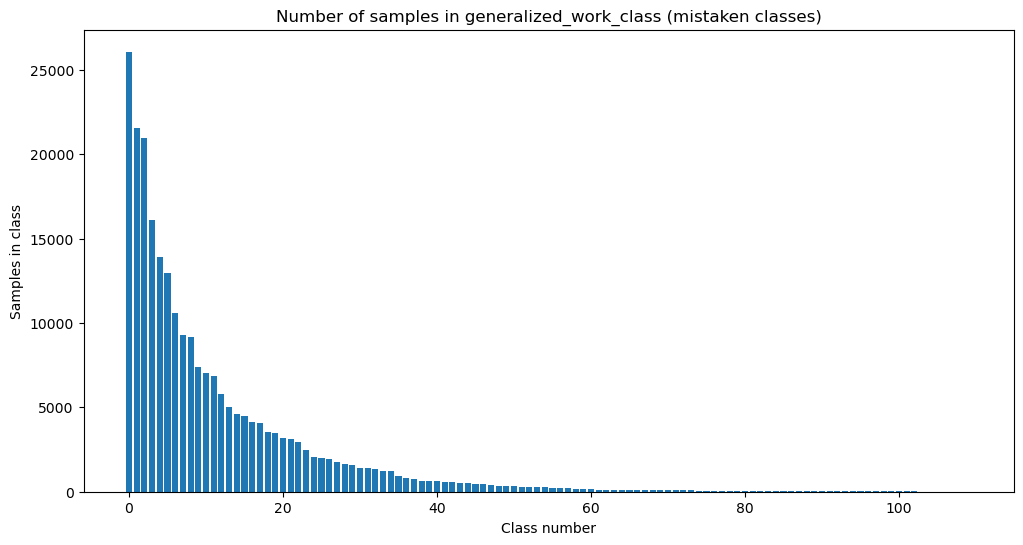

In [278]:
vals = mistake_data['generalized_work_class'].value_counts()
idx_plot = [i for i in range(len(vals))]
# idx_plot = list(vals.index)

plt.figure(figsize=(12, 6))
plt.bar(idx_plot, vals)
plt.title('Number of samples for classes, where mistakes were made')
plt.xlabel('Class number')
plt.ylabel('Samples in class')
plt.show()

## Other models implementation

In [22]:
def show_metrics1(predictions):
    f1_score_1_micro = f1_score(y1_val, predictions, average='micro')
    f1_score_1_macro = f1_score(y1_val, predictions, average='macro')
    
    show_df = pd.DataFrame(
        {
        'generalized_work_class': [f1_score_1_micro, f1_score_1_macro]
        },
        index=['F1 micro', 'F1 macro']
    ).round(3)
    
    return show_df

In [23]:
def show_metrics2(predictions):
    f1_score_2_micro = f1_score(y2_val, predictions, average='micro')
    f1_score_2_macro = f1_score(y2_val, predictions, average='macro')
    
    show_df = pd.DataFrame(
        {
        'global_work_class': [f1_score_2_micro, f1_score_2_macro]
        },
        index=['F1 micro', 'F1 macro']
    ).round(6)
    
    return show_df

In [287]:
knn =  KNeighborsClassifier(weights="distance")
rfc = RandomForestClassifier()

# Printing the individual accuracy of the models
classifications = [knn,rfc]
for algo in classifications:
    score = cross_val_score(algo, X_train, y1_train, cv = 5,scoring = 'f1_macro')
    print("The accuracy score of {} is:".format(algo),score.mean())

D:\Conda\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


The accuracy score of KNeighborsClassifier(weights='distance') is: 0.939949709120403


D:\Conda\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


The accuracy score of RandomForestClassifier() is: 0.9374340361538351


In [24]:
moment1 = time()
knn1 =  KNeighborsClassifier(weights="distance")
knn1.fit(X_train, y1_train)
moment2 = time()

knn1_preds = knn1.predict(X_val)
moment3 = time()

print(f"Time for training, s: {(moment2-moment1):.2f}")
print(f"Time for validation, s: {(moment3-moment2):.2f}")

Time for training, s: 0.49
Time for validation, s: 8.23


In [26]:
show_metrics1(knn1_preds)

,generalized_work_class
F1 micro,0.994
F1 macro,0.972


In [27]:
moment1 = time()
knn2 =  KNeighborsClassifier(weights="distance")
knn2.fit(X_train, y2_train)
moment2 = time()

knn2_preds = knn2.predict(X_val)
moment3 = time()

print(f"Time for training, s: {(moment2-moment1):.2f}")
print(f"Time for validation, s: {(moment3-moment2):.2f}")

Time for training, s: 0.41
Time for validation, s: 7.56


In [28]:
show_metrics2(knn2_preds)

,global_work_class
F1 micro,0.995419
F1 macro,0.994231


In [30]:
knn1_preds_series = pd.Series(knn1_preds, index=y1_val.index, name="generalized_work_class")
knn2_preds_series = pd.Series(knn2_preds, index=y1_val.index, name="global_work_class")

In [33]:
# generalized_predicted_class = pd.Series(
#     generalized_encoder.inverse_transform(predictions[0].reshape(-1, 1)).flatten(),
#     index=X_val.index,
#     name="generalized_work_class",
# ) # Form generalized_work_class series

# global_predicted_class = pd.Series(
#     global_encoder.inverse_transform(predictions[1].reshape(-1, 1)).flatten(),
#     index=X_val.index,
#     name="global_work_class",
# ) # Form global_work_class series

row1 = pd.Series(
    generalized_encoder.transform(sur_keys_data \
                             .generalized_work_class \
                             .values.reshape(-1, 1)) \
                             .flatten(),
    name="generalized_work_class")

row2 = pd.Series(
    global_encoder.transform(sur_keys_data \
                             .global_work_class \
                             .values.reshape(-1, 1)) \
                             .flatten(),
    name="global_work_class")

sur_keys_encoded = pd.concat([row1, row2], axis=1)
sur_keys_encoded.head(2)

,generalized_work_class,global_work_class
0,132.0,54.0
1,157.0,26.0


In [34]:
knns_def_preds = knn1_preds_series.to_frame()\
            .merge(sur_keys_encoded, on="generalized_work_class", how="left")\
            .set_index(y1_val.index)
knns_def_preds.head(2)

,generalized_work_class,global_work_class
400713,165.0,32.0
195157,188.0,44.0


In [35]:
knn_idxs = knns_def_preds.global_work_class[knns_def_preds.global_work_class.isna()].index

In [36]:
knns_def_preds.loc[knn_idxs, "global_work_class"] = knn2_preds_series[knn_idxs]

In [37]:
knn_pred_gen = knns_def_preds.generalized_work_class.values
knn_pred_glob = knns_def_preds.global_work_class.values

In [38]:
show_metrics1(knn_pred_gen)

,generalized_work_class
F1 micro,0.994
F1 macro,0.972


In [39]:
show_metrics2(knn_pred_glob)

,global_work_class
F1 micro,0.995284
F1 macro,0.994038


In [40]:
show_metrics2(knn2_preds)

,global_work_class
F1 micro,0.995419
F1 macro,0.994231


## Recovering data from a prediction

In [41]:
generalized_predicted_class = pd.Series(
    generalized_encoder.inverse_transform(knn1_preds.reshape(-1, 1)).flatten(),
    index=X_val.index,
    name="generalized_work_class",
) # Form generalized_work_class series
global_predicted_class = pd.Series(
    global_encoder.inverse_transform(knn2_preds.reshape(-1, 1)).flatten(),
    index=X_val.index,
    name="global_work_class",
) # Form global_work_class series

In [45]:
val_dataframe_from_predictions = pd.concat(
    (X_val_raw, generalized_predicted_class, global_predicted_class), axis=1
) # Form val dataframe from predicted values

In [46]:
mistakes_recovered = val_dataframe_from_predictions[
    (
        val_dataframe_from_predictions["generalized_work_class"]
        != data.loc[X_val_raw.index, "generalized_work_class"]
    )
    | (
        val_dataframe_from_predictions["global_work_class"]
        != data.loc[X_val_raw.index, "global_work_class"]
    )
] # Get the rows of the recovered dataframe where the errors occurred
mistakes_original = data.loc[X_val_raw.index][
    (
        data.loc[X_val_raw.index, "generalized_work_class"]
        != val_dataframe_from_predictions["generalized_work_class"]
    )
    | (
        data.loc[X_val_raw.index, "global_work_class"]
        != val_dataframe_from_predictions["global_work_class"]
    )
].drop(columns="upper_works") # Get the rows of the original dataframe where the errors occurred

In [323]:
print(f'Число ошибок: {mistakes_recovered.shape[0]} из {val_dataframe_from_predictions.shape[0]} предсказаний')
print()
print('Оригинал:')
display(mistakes_original.sample(10, random_state=42))
print('Восстановлено по предсказаниям:')
display(mistakes_recovered.sample(10, random_state=42))

Число ошибок: 82 из 14843 предсказаний

Оригинал:


,work_name,generalized_work_class,global_work_class
708160,насос не подключен,Монтаж насоса,Монтаж
215167,тх. спортзал. монтаж трибуны,Монтаж мк,Монтаж мк
79448,2.14.5 монтаж гидранта,Монтаж оборудования,Монтаж
113717,изоляция емкости,Монтаж мк,Монтаж мк
528563,монтаж стоек (поз.4 кгс-2 тх),Монтаж мк,Монтаж мк
202088,"изготовление и монтаж ограждения огл 45-12,5.18",Изготовление и монтаж вентиляции,Изготовление и монтаж
293626,"монтаж балок б2,б (двутавр 20б1-9,6х2м.; швелл...",Монтаж мк,Монтаж мк
292059,"монтаж м/к шахты воздухозаборная (ростверк, тр...",Монтаж ростверков,Монтаж свай
381868,монтаж м/к оголовников опор под трубопроводы,Монтаж оголовков,Монтаж свай
261208,"демонтажные работы, кабель муфты",Демонтаж,Демонтаж


Восстановлено по предсказаниям:


,work_name,generalized_work_class,global_work_class
708160,насос не подключен,Демонтаж,Демонтаж
215167,тх. спортзал. монтаж трибуны,Монтаж блока ЗРУ,Монтаж блока
79448,2.14.5 монтаж гидранта,Монтаж приборов,Монтаж
113717,изоляция емкости,Изоляция сварных соединений,Изоляция
528563,монтаж стоек (поз.4 кгс-2 тх),Монтаж приборов,Монтаж
202088,"изготовление и монтаж ограждения огл 45-12,5.18",Монтаж лестниц,Изготовление и монтаж
293626,"монтаж балок б2,б (двутавр 20б1-9,6х2м.; швелл...",Монтаж траверс,Монтаж
292059,"монтаж м/к шахты воздухозаборная (ростверк, тр...",Монтаж оголовков,Монтаж свай
381868,монтаж м/к оголовников опор под трубопроводы,Монтаж опор трубопровода,Монтаж опор
261208,"демонтажные работы, кабель муфты",Монтаж мелких комплектующих кабеля,Монтаж электрики


In [47]:
len(mistakes_recovered.index)

82

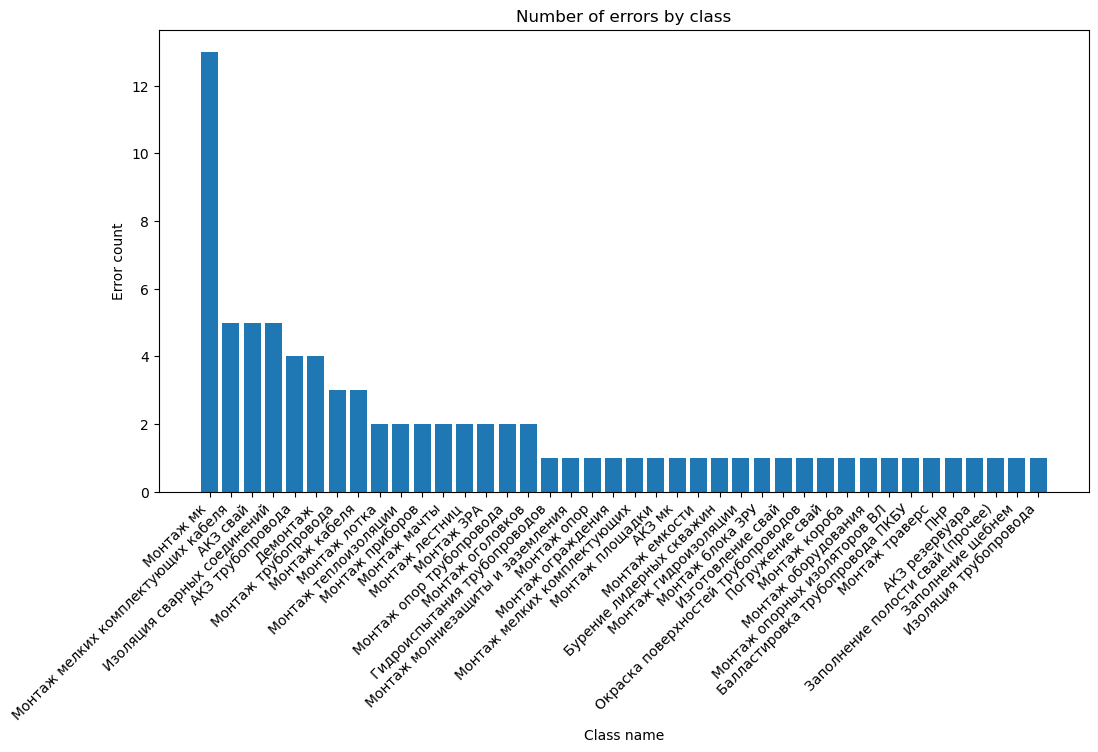

In [51]:
vals = mistakes_recovered['generalized_work_class'].value_counts()
# idx = [i for i in range(len(vals))]
idx = vals.index

plt.figure(figsize=(12, 6))
plt.bar(idx, vals)
plt.title('Number of errors by class')
plt.xlabel('Class name')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Error count')
plt.show()

In [324]:
val_dataframe_from_predictions_slice = val_dataframe_from_predictions.loc[knn_idxs]
len(val_dataframe_from_predictions_slice)

48

In [325]:
mistakes_nosur_recovered = val_dataframe_from_predictions_slice[
    (
        val_dataframe_from_predictions.loc[knn_idxs, "generalized_work_class"]
        != data.loc[knn_idxs, "generalized_work_class"]
    )
    | (
        val_dataframe_from_predictions.loc[knn_idxs, "global_work_class"]
        != data.loc[knn_idxs, "global_work_class"]
    )
]

In [326]:
print(f'Число ошибок: {mistakes_nosur_recovered.shape[0]} из 48') 

Число ошибок: 0 из 48
